# DQN test with pytorch

From Miguel's Book, combined with my old code.

https://github.com/furrrow/CS7642/blob/master/Project%204/cartpole/Cartpole_DQN.ipynb

https://github.com/mimoralea/gdrl/blob/master/notebooks/chapter_09/chapter-09.ipynb

In [1]:
# will take some of miguel's import statements, but not all.
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

In [3]:
# don't forget the nvidia smi command
!nvidia-smi

Fri Jul  8 12:27:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  6%   62C    P2    42W / 151W |   1112MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
"""
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.
Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
    Note: The amount the velocity that is reduced or increased is not
    fixed; it depends on the angle the pole is pointing. This is because
    the center of gravity of the pole increases the amount of energy needed
    to move the cart underneath it
Reward:
    Reward is 1 for every step taken, including the termination step
Starting State:
    All observations are assigned a uniform random value in [-0.05..0.05]
Episode Termination:
    Pole Angle is more than 12 degrees.
    Cart Position is more than 2.4 (center of the cart reaches the edge of
    the display).
    Episode length is greater than 200.|
    Solved Requirements:
    Considered solved when the average return is greater than or equal to
    195.0 over 100 consecutive trials.
"""
# what to do? let's see what are the 4 observations:
env = gym.make("CartPole-v1")
n_action = env.action_space.n
n_states = env.observation_space.shape[0]
input_shape= env.observation_space.shape
print("action space:", env.action_space)
print("observation space:", env.observation_space)
print("input shape:", input_shape)
env.reset() 

action space: Discrete(2)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
input shape: (4,)


array([-0.03817999,  0.00834115,  0.01671322,  0.02833405], dtype=float32)

In [6]:
# create a replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'terminal'))


class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def save(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# miguel has an image based version, I need to start with a state based one... 
class simpleModel(nn.Module):

    def __init__(self, in_features=n_states, outputs=n_action):
        super(simpleModel, self).__init__()
        self.linear1 = nn.Linear(in_features, 512)
        self.linear2 = nn.Linear(512, 128)
#         self.linear3 = nn.Linear(128, 64)
        self.final = nn.Linear(128, outputs)
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, x):
        x = self._format(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
        x = F.relu(self.final(x))
        return x
    
    def load(self, experiences):
        batch = Transition(*zip(*experiences))
        
        states = np.array(batch.state)
        actions = np.array(batch.action)
        new_states = np.array(batch.next_state)
        rewards = np.array(batch.reward)
        is_terminals = np.array(batch.terminal)
        
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        new_states = torch.from_numpy(new_states).float().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        is_terminals = torch.from_numpy(is_terminals).float().to(device)
        return states, actions, new_states, rewards, is_terminals

In [8]:
online_model = simpleModel()
target_model = simpleModel()
print(online_model)

simpleModel(
  (linear1): Linear(in_features=4, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=2, bias=True)
)


In [9]:
# summary(online_model, input_size=(128, 4))

In [10]:
# action selection strategy
def e_greedy_policy(model, epsilon, state, action_space=n_action):
    if np.random.random() < epsilon: # random action
        return np.random.randint(action_space)
    else:  # greedy
        q_values = model(state).cpu().detach()
        q_values = q_values.data.numpy()
        return np.argmax(q_values)

In [11]:
# pre populate a starting library of experiences
memory = ReplayBuffer(50000)
initial_size = 5000

while len(memory) < initial_size:
    state = env.reset()
    terminal = False
    tmp_reward = 0
    
    while not terminal:
        action = env.action_space.sample()
        (next_state, reward, done, info) = env.step(action)
        if "TimeLimit" in info:
            print(info)
            print("terminating episode...")
            done = False
            terminal = True
        memory.save(state, action, next_state, reward, done)
        terminal = done
        state = next_state
        tmp_reward += reward
print(len(memory), "entries saved to ReplayBuffer")

5005 entries saved to ReplayBuffer


In [12]:
n_episodes = 750
reward_record = []
avg_record = []
best_score = 75
update_interval = 150
epsilon=0.5
eps_decay = 0.995
batch_size = 64
learning_rate = 0.0005
gamma=1
# optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(online_model.parameters(), lr=learning_rate)
count = 0
solved = False

for episode in range(n_episodes):
    state = env.reset()
    terminal = False
    tmp_reward = 0
    epoch_loss_list = []
    if solved:
        break
    
    while not terminal:         
        # select action
        action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
        (next_state, reward, done, info) = env.step(action)
        # handle cases when it reaches a time limit but not actually terminal
        if "TimeLimit" in info:
            print(info)
            print("terminating episode...")
            done = False
            terminal = True
        memory.save(state, action, next_state, reward, done)
        terminal = done
        state = next_state
        tmp_reward += reward
        count += 1
        
        # sample random minibatch
        transitions = memory.sample(batch_size)
        (states, actions, new_states, rewards, is_terminals) = online_model.load(transitions)
        
        # Q target
        continue_mask = 1 - is_terminals  # if terminal, then = 0
        Q_next = target_model(new_states).detach()  # gradient does NOT involve the target
        Q_next_max = Q_next.max(1)[0]  # (batch_size)
        Q_target = rewards + Q_next_max * continue_mask * gamma
        Q_target = Q_target.unsqueeze(1) # (batch_size x 1)

        # fit the model
        Q_values = online_model(states).gather(1, actions.unsqueeze(1)) # batch_size x 1
#             MSE = (Q_values - Q_target).pow(2).mul(0.5).mean()
#             criterion = nn.SmoothL1Loss()
        criterion = torch.nn.MSELoss()
        # td_error = Q_values - Q_target
        # value_loss = td_error.pow(2).mul(0.5).mean()
        loss = criterion(Q_values, Q_target)
        loss_value = loss.data.cpu().numpy().copy()
        epoch_loss_list.append(loss_value)

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update target network periodically
        if count % update_interval == 0:
#             print("updating target model")
            for target, online in zip(target_model.parameters(), online_model.parameters()):
                target.data.copy_(online.data)

    rolling_average = np.mean(reward_record[-100:])
    reward_record.append(tmp_reward)
    avg_record.append(rolling_average)
    avg_loss = np.average(epoch_loss_list)
    epsilon = max(epsilon*eps_decay, 0.005)
    if episode % 10 == 0:
         print(f"episode {episode:2d} avg_loss {avg_loss:3.3f} epsilon {epsilon:3.3f} reward {tmp_reward}")

    if not solved:
        if rolling_average > 200:
            print(f"!!! exceeded benchmark at epoch {episode} rolling average {rolling_average:.3f}")
            solved = True
    if tmp_reward > best_score:
        best_score = tmp_reward
        print(f"new best score {best_score:.2f} episode {episode} rolling avg {rolling_average:.3f}")
    

/home/jim/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jim/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode  0 avg_loss 0.083 epsilon 0.497 reward 16.0
episode 10 avg_loss 0.003 epsilon 0.473 reward 13.0
episode 20 avg_loss 0.034 epsilon 0.450 reward 10.0
episode 30 avg_loss 0.083 epsilon 0.428 reward 21.0
episode 40 avg_loss 0.243 epsilon 0.407 reward 326.0
new best score 326.00 episode 40 rolling avg 15.500
episode 50 avg_loss 0.687 epsilon 0.387 reward 114.0
episode 60 avg_loss 2.044 epsilon 0.368 reward 115.0
episode 70 avg_loss 3.915 epsilon 0.350 reward 47.0
new best score 330.00 episode 72 rolling avg 60.458
episode 80 avg_loss 4.549 epsilon 0.333 reward 237.0
episode 90 avg_loss 7.478 epsilon 0.317 reward 66.0
episode 100 avg_loss 9.460 epsilon 0.301 reward 265.0
episode 110 avg_loss 9.096 epsilon 0.287 reward 220.0
episode 120 avg_loss 9.774 epsilon 0.273 reward 148.0
episode 130 avg_loss 10.426 epsilon 0.259 reward 500.0
new best score 500.00 episode 130 rolling avg 133.820
episode 140 avg_loss 13.020 epsilon 0.247 reward 156.0
episode 150 avg_loss 12.055 epsilon 0.235 rewa

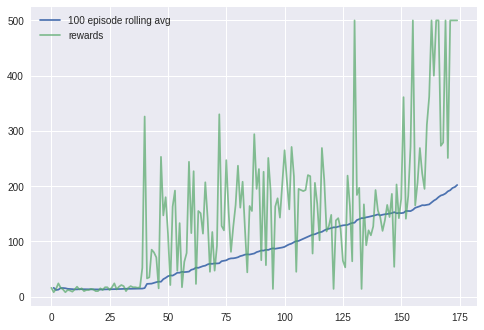

In [13]:
plt.style.use('seaborn')
plt.plot(avg_record, label='100 episode rolling avg')
plt.plot(reward_record, alpha=0.7, label='rewards')
plt.legend()

In [48]:
def run_dqn():
    online_model = simpleModel()
    target_model = simpleModel()
    
    n_episodes = 1000
    reward_record = []
    avg_record = [0]
    best_score = 75
    update_interval = 150
    epsilon=0.5
    batch_size = 64
    learning_rate = 0.0005
    gamma=1
    # optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
    optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
    count = 0

    for episode in range(n_episodes):
        state = env.reset()
        terminal = False
        tmp_reward = 0

        while not terminal:         
            # select action
            action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
            (next_state, reward, done, info) = env.step(action)
            # handle cases when it reaches a time limit but not actually terminal
            if ("TimeLimit" in info):
                print(info)
                print("terminating episode...")
                done = False
                terminal = True
            memory.save(state, action, next_state, reward, done)
            terminal = done
            state = next_state
            tmp_reward += reward
            count += 1

            # sample random minibatch
            transitions = memory.sample(batch_size)
            (states, actions, new_states, rewards, is_terminals) = online_model.load(transitions)

            # Q target
            continue_mask = 1 - is_terminals  # if terminal, then = 0
            Q_next = target_model(new_states).detach()  # gradient does NOT involve the target
            Q_next_max = Q_next.max(1)[0]  # (batch_size)
            Q_target = rewards + Q_next_max * continue_mask * gamma
            Q_target = Q_target.unsqueeze(1) # (batch_size x 1)

            # fit the model
            Q_values = online_model(states).gather(1, actions.unsqueeze(1)) # batch_size x 1
    #             MSE = (Q_values - Q_target).pow(2).mul(0.5).mean()
    #             criterion = nn.SmoothL1Loss()
            criterion = torch.nn.MSELoss()
            # td_error = Q_values - Q_target
            # value_loss = td_error.pow(2).mul(0.5).mean()
            loss = criterion(Q_values, Q_target)
            loss_value = loss.data.cpu().numpy().copy()

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update target network periodically
            if count % update_interval == 0:
    #             print("updating target model")
                for target, online in zip(target_model.parameters(), online_model.parameters()):
                    target.data.copy_(online.data)

        rolling_average = np.mean(reward_record[-100:])
        reward_record.append(tmp_reward)
        avg_record.append(rolling_average)
        epsilon = max(epsilon*eps_decay, 0.005)
    return reward_record, avg_record

In [49]:
%%time
rolling_record = []
for trial in range(5):
    rewards_record, avg_record = run_dqn()
    rolling_record.append(avg_record)
    print("rep max rolling rewards", max(avg_record))

/home/jim/Documents/Classes/CS7641/MachineLearning/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jim/Documents/Classes/CS7641/MachineLearning/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rep max rolling rewards 451.99
rep max rolling rewards 15.0
rep max rolling rewards 364.61
rep max rolling rewards 397.86
rep max rolling rewards 402.71
CPU times: user 16min 40s, sys: 6.98 s, total: 16min 47s
Wall time: 16min 43s


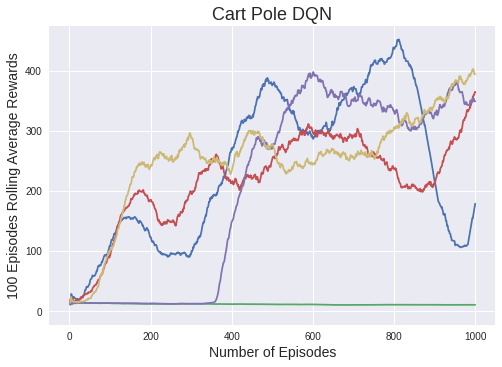

In [50]:
plt.style.use('seaborn')
plt.figure()
plt.title('Cart Pole DQN', fontsize = 18)
plt.xlabel("Number of Episodes", fontsize=14)
plt.ylabel("100 Episodes Rolling Average Rewards", fontsize=14)
for record in rolling_record:
    plt.plot(record)
plt.savefig("Cartpole_dqn.png")

In [55]:
# np.save('dqn_results.npy', np.array(rolling_record))
# np.load('dqn_results.npy')

In [96]:
# # load saved model
# model = simpleModel()
# optimizer = optim.Adam(model.parameters())

# checkpoint = torch.load(name)
# print(name, "loaded")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

simpleModel_1024_258.pth loaded


In [27]:
# let's see what the model has learned
obervations = env.reset()
for i in range(3):
    env.render()
    epsilon = 0.005
    action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
    state, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

NameError: name 'model' is not defined